In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten,MaxPool2D, AvgPool2D,Conv2D,concatenate,Input,Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Read in data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
ytrain = train["label"].values
#ytest = train["label"].values
Xtrain = train.drop("label",axis=1).values
Xtest = test.values
y_train_cat = to_categorical(ytrain)
#y_test_cat = to_categorical(ytest)

for drawing

In [4]:
Xtrainpic = Xtrain.reshape(Xtrain.shape[0],int(sqrt(Xtrain.shape[1])),int(sqrt(Xtrain.shape[1])))
negativeMask=np.ones(784).reshape(28,28)*255

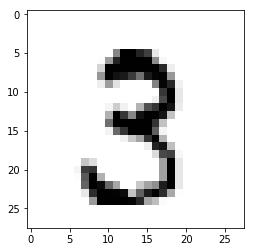

In [5]:
plt.imshow(negativeMask-Xtrainpic[36], cmap='gray')

Helper (wrapper) functions

In [6]:
def prep_subm(Xtest,model):
    ytest = model.predict(Xtest)
    pred=list(map(lambda x: list(x).index(max(x)),ytest))
    idx = range(1,len(pred)+1)
    subm = pd.DataFrame(data={'ImageId':idx,'Label':pred})
    subm.to_csv("subm.csv",index=False)
    
def mis_data(Xtrain,model,ytrain):
    ypred = model.predict(Xtrain)
    predTrain=list(map(lambda x: list(x).index(max(x)),ypred))
    cDF = pd.DataFrame({'original':ytrain,'predicted':predTrain})
    cDF2=cDF[cDF['original']!=cDF['predicted']]
    print(pd.crosstab(cDF2['original'],cDF2['predicted'],margins = True))
    return cDF2

def check_mis(org,pred,Xtrain,cDF2):
    return Xtrain[cDF2.loc[(cDF2['original']==org) & (cDF2['predicted']==pred),:].index]

Reshaping data for model

In [7]:
Xtrain = Xtrain.reshape(-1, 28, 28, 1)
Xtest = Xtest.reshape(-1, 28, 28, 1)

Starting model (best working so far)

In [8]:
K.clear_session()
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate


main_input = Input((28, 28, 1), name='image')
x = Conv2D(64, (12, 12),name="conv12",activation='relu')(main_input)
x = AvgPool2D(pool_size=(4, 4))(x)
x = Conv2D(32, (3, 3),name="conv3",activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
#x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
main_output = Dense(10,activation='softmax')(x)
model = Model(inputs=main_input, outputs=main_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv12 (Conv2D)              (None, 17, 17, 64)        9280      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
__________

In [14]:
model.fit(Xtrain, y_train_cat, batch_size=32,
          epochs=50, verbose=1, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='loss', min_delta=0, patience=3)])


Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 23s - loss: 0.3513 - acc: 0.9107 - val_loss: 0.2126 - val_acc: 0.9413
Epoch 2/50
33600/33600 [==============================] - 23s - loss: 0.1192 - acc: 0.9654 - val_loss: 0.0994 - val_acc: 0.9712
Epoch 3/50
33600/33600 [==============================] - 23s - loss: 0.0913 - acc: 0.9726 - val_loss: 0.1428 - val_acc: 0.9593
Epoch 4/50
33600/33600 [==============================] - 23s - loss: 0.0757 - acc: 0.9776 - val_loss: 0.0824 - val_acc: 0.9777
Epoch 5/50
33600/33600 [==============================] - 23s - loss: 0.0651 - acc: 0.9804 - val_loss: 0.0803 - val_acc: 0.9777
Epoch 6/50
33600/33600 [==============================] - 23s - loss: 0.0664 - acc: 0.9806 - val_loss: 0.0674 - val_acc: 0.9820
Epoch 7/50
33600/33600 [==============================] - 23s - loss: 0.0550 - acc: 0.9842 - val_loss: 0.0825 - val_acc: 0.9775
Epoch 8/50
33600/33600 [==============================]

In [18]:
cDF2 = mis_data(Xtrain,model,ytrain)

predicted   0   1   2  3   4   5   6   7   8   9  All
original                                             
0           0   0   3  0   1   3   2   0   1   2   12
1           1   0   2  0   0   1   3   2   4   4   17
2           3   2   0  2   2   0   2  11   1   0   23
3           2   0  11  0   0  20   0   4   2   4   43
4           0   2   0  0   0   0   1   7   4   6   20
5           1   0   1  4   0   0   0   0   4   1   11
6           3   0   0  0   0   4   0   0   3   0   10
7           0   2   6  0   0   0   0   0   0   5   13
8           4   3  10  0   0   6   3   2   0  24   52
9           4   2   0  3  14  17   0   8   1   0   49
All        18  11  33  9  17  51  11  34  20  46  250


Model does pretty well. It's worth mentioning that the aim here should not be to get 100% accuracy (there are data that in my opinion are mislabelled and some are ambiguous). In the data 8 gets most often misclassified. But we may try to tune model to diminish most often misclassified ones

Let's inspect a few examples

First original 8, predicted 9

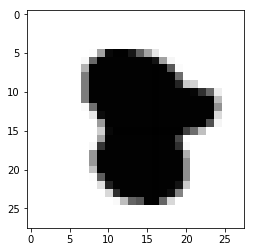

In [19]:
Xmis=check_mis(8,9,Xtrainpic,cDF2)
plt.imshow(negativeMask-Xmis[2], cmap='gray')

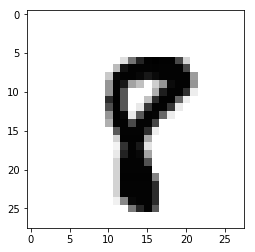

In [20]:
plt.imshow(negativeMask-Xmis[12], cmap='gray')

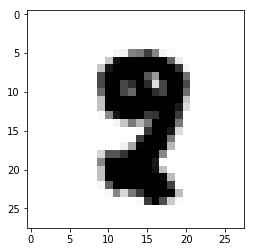

In [39]:
plt.imshow(negativeMask-Xmis[18], cmap='gray')

Most indeed seems to be 8's. But for example this one I'd rather say it's 9 (or even rather 2). Let's see 3 vs 5

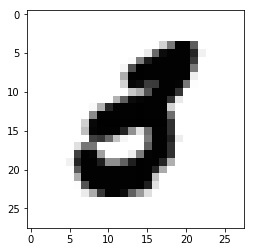

In [41]:
Xmis=check_mis(3,5,Xtrainpic,cDF2)
plt.imshow(negativeMask-Xmis[2], cmap='gray')

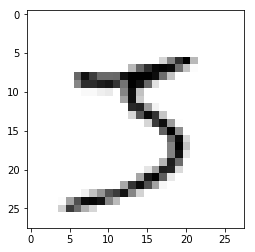

In [46]:
Xmis=check_mis(3,5,Xtrainpic,cDF2)
plt.imshow(negativeMask-Xmis[7], cmap='gray')

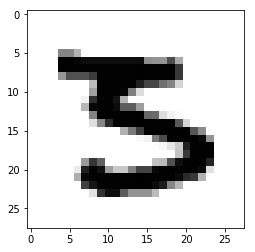

In [47]:
plt.imshow(negativeMask-Xmis[18], cmap='gray')

Indeed some of those seem to be clearly misclassified, other are not that obvious

In [8]:
K.clear_session()
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate


main_input = Input((28, 28, 1), name='image')
x = Conv2D(64, (12, 8),activation='relu')(main_input)
#x = Conv2D(64, (6, 2),activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3),activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(128,activation='relu')(x)
main_output = Dense(10,activation='softmax')(x)
model = Model(inputs=main_input, outputs=main_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 21, 64)        6208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 10, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               98432     
__________

In [9]:
model.fit(Xtrain, y_train_cat, batch_size=32,
          epochs=50, verbose=1, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='acc', min_delta=0, patience=3)])

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 34s - loss: 0.6851 - acc: 0.9042 - val_loss: 0.1237 - val_acc: 0.9644
Epoch 2/50
33600/33600 [==============================] - 33s - loss: 0.1090 - acc: 0.9676 - val_loss: 0.0931 - val_acc: 0.9757
Epoch 3/50
33600/33600 [==============================] - 34s - loss: 0.0877 - acc: 0.9743 - val_loss: 0.0970 - val_acc: 0.9727
Epoch 4/50
33600/33600 [==============================] - 35s - loss: 0.0742 - acc: 0.9785 - val_loss: 0.0986 - val_acc: 0.9740
Epoch 5/50
33600/33600 [==============================] - 34s - loss: 0.0641 - acc: 0.9822 - val_loss: 0.0898 - val_acc: 0.9785
Epoch 6/50
33600/33600 [==============================] - 33s - loss: 0.0640 - acc: 0.9825 - val_loss: 0.0813 - val_acc: 0.9789
Epoch 7/50
33600/33600 [==============================] - 34s - loss: 0.0500 - acc: 0.9857 - val_loss: 0.1132 - val_acc: 0.9760
Epoch 8/50
33600/33600 [==============================]

In [10]:
cDF2 = mis_data(Xtrain,model,ytrain)

predicted   0  1   2   3   4   5   6   7   8    9  All
original                                              
0           0  0   1   0   2   1   4   0   1   10   19
1           7  0   3   0   2   3   5  13   2   23   58
2           7  1   0   7   0   3   3   3   5    1   30
3           2  0   3   0   0   3   1   0   0    3   12
4           0  1   0   0   0   0   3   4   1   37   46
5           1  0   0   7   1   0   3   0   1    3   16
6           6  0   0   0   1   2   0   0   0    3   12
7           1  1  17   2   1   1   0   0   1   13   37
8           1  4   0  11   2  29   6   1   0   63  117
9           2  0   0   1   5   6   0   2   0    0   16
All        27  7  24  28  14  48  25  23  11  156  363


In [16]:
Xtrain = np.pad(Xtrain, ((0,0),(2,2),(2,2),(0,0)), 'constant')
Xtest = np.pad(Xtest, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [17]:
Xtrain.shape

(42000, 32, 32, 1)

In [31]:
from keras.models import Sequential
from keras.layers import MaxPooling2D,AveragePooling2D,Dense,Flatten,Conv2D
K.clear_session()
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=5, activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [32]:
model.fit(Xtrain, y_train_cat, batch_size=64,
          epochs=50, verbose=1, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='acc', min_delta=0, patience=2)])

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 15s - loss: 0.6654 - acc: 0.9033 - val_loss: 0.1078 - val_acc: 0.9673
Epoch 2/50
33600/33600 [==============================] - 15s - loss: 0.0794 - acc: 0.9763 - val_loss: 0.0864 - val_acc: 0.9727
Epoch 3/50
33600/33600 [==============================] - 15s - loss: 0.0535 - acc: 0.9833 - val_loss: 0.0641 - val_acc: 0.9802
Epoch 4/50
33600/33600 [==============================] - 15s - loss: 0.0401 - acc: 0.9877 - val_loss: 0.0642 - val_acc: 0.9820
Epoch 5/50
33600/33600 [==============================] - 15s - loss: 0.0376 - acc: 0.9880 - val_loss: 0.0693 - val_acc: 0.9814
Epoch 6/50
33600/33600 [==============================] - 16s - loss: 0.0284 - acc: 0.9909 - val_loss: 0.0629 - val_acc: 0.9821
Epoch 7/50
33600/33600 [==============================] - 16s - loss: 0.0275 - acc: 0.9911 - val_loss: 0.0789 - val_acc: 0.9786
Epoch 8/50
33600/33600 [==============================]

In [28]:
prep_subm(Xtest,model)

In [33]:
cDF2 = mis_data(Xtrain,model,ytrain)

predicted  0   1   2   3   4   5   6   7   8   9  All
original                                             
0          0   2   9   1   0   1  28   0   2   1   44
1          0   0   3   1   3   0   1   2   3   0   13
2          1   2   0  13   0   1   1   3   6   1   28
3          0   0   4   0   0  24   1   0   1   2   32
4          0   1   0   0   0   0   5   1   2   4   13
5          0   0   0   1   1   0  22   0   9   1   34
6          2   2   0   0   2   0   0   0   1   0    7
7          0   1  10   7   1   0   0   0   0   7   26
8          1   6  13   3   0   2   7   0   0   3   35
9          1   0   0   2  13   9   1   6   4   0   36
All        5  14  39  28  20  37  66  12  28  19  268


Classic model (even though quite simple) does better than my models. 

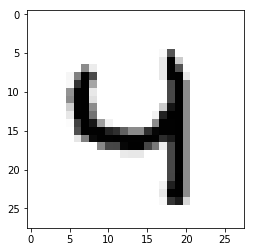

In [26]:
Xmis=check_mis(4,9,Xtrainpic,cDF2)
plt.imshow(negativeMask-Xmis[0], cmap='gray')